Must run NPX_save_evoked_CSD notebook to create the CSD epoched files.

In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from scipy import signal, fftpack
from datetime import date

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
# from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

Load Zap_Zip-log_exp to get metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [6]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [7]:
area_colors = {
    'MO': 'blue', # [31, 157, 90]
    'ACA': 'deepskyblue', # [64, 166, 102]
    'SS': 'blueviolet', # [24, 128, 100]
    'VIS': 'green', # [8, 133, 140]
    'MO-TH': 'steelblue', # [255, 112, 128]
#     'VIS-TH': 'olivedrab'
}

In [8]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

#### Functions

In [9]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='all'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [10]:
def get_zFR(trig_FR, FRtime):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
    baseline_avg = np.mean(trig_FR[FRtime < 0, :], axis=0)
    baseline_std = np.std(trig_FR[FRtime < 0, :], axis=0)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[:, nonzero_inds] = (trig_FR[:, nonzero_inds] - baseline_avg[None, nonzero_inds]) / baseline_std[None, nonzero_inds]
    
    return trig_Z

In [11]:
def get_metadata(mdata_dict, metadf):
    exp_meta = metadf[(
        (metadf['mouse_name'].str.contains(mdata_dict['exp'].mouse)) &
        (metadf['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata_dict['exp'].experiment_folder))))
    )].squeeze()
    
    ## Gets EEG_bad_chs, stim_currents, and PCI_stim ##
    try:
        EEG_bad_chs = mdata_dict['bad_chs']
    except KeyError:
        badchstr = exp_meta['EEG bad_channels'].replace(' ','')
        EEG_bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                EEG_bad_chs.append(int(char))
    currentstr = exp_meta['Current (uA)'].replace(' ','')
    stim_currents = []
    for char in currentstr.split('/'):
        if char.isdecimal():
            stim_currents.append(char)
    if len(stim_currents) > 1:
        PCI_stim = stim_currents[1]
    elif len(currents_list) == 1:
        PCI_stim = stim_currents[0]
    else:
        print('No stim current listed in Zap_Zip-log_exp')
    return EEG_bad_chs, stim_currents, PCI_stim

## Load subjects from file

In [12]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [13]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_CSD_subjects.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [14]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\LFP_analyses'
# plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GRC2022_poster'

## Choose example subjects and load experiment

In [15]:
example_mice = {
    'MOs_deep': '571619',
#     'SSp_superficial': '599017',
#     'SSp_deep': '599017',
}

In [16]:
ex_sub_dict = {x: {} for x in example_mice.keys()}
for group, mouse in example_mice.items():
    print('{} - {}'.format(group, mouse))
    ex_sub_dict[group][mouse] = multi_sub_dict[group][mouse]
    ex_sub_dict[group][mouse]['exp'] = EEGexp(multi_sub_dict[group][mouse]['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_deep - 571619
Experiment type: electrical stimulation



## Gather data for CSD only

In [17]:
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

In [18]:
for group, group_subs in ex_sub_dict.items():
    print(group)
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        mdata['data'] = {}
        
        ## Load CSD info and traces ##
        with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
            CSDinfo = json.load(info_file)
        CSD_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
        
        ## Grab exp metadata from Zap_Zip-log_exp ##
        bad_chs, currents_list, PCI_stim_amp = get_metadata(mdata, zzmetadata)

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
            
        ## Load regional CSD ##
        reg_allLFPtraces = {}
        reg_allCSDtraces = {}
        for region in areas_of_interest.keys():
            if region in CSDinfo.keys():
                reg_allLFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
                reg_allCSDtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedCSDtraces.npy'))
        
        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in ['awake', 'anesthetized']:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][statei] = np.concatenate(state_events)
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)
        LFP_traces = {}
        CSD_traces = {}
        for leveli, states_event_times in all_event_inds.items():
            LFP_traces[leveli] = {}
            CSD_traces[leveli] = {}
            for statei in test_states:
                event_inds = states_event_times[statei]
                LFP_traces[leveli][statei] = {}
                CSD_traces[leveli][statei] = {}
                for region in reg_allCSDtraces.keys():
                    LFP_traces[leveli][statei][region] = [CSD_event_ts, reg_allLFPtraces[region][:, :, event_inds]]
                    CSD_traces[leveli][statei][region] = [CSD_event_ts, reg_allCSDtraces[region][:, :, event_inds]]
        mdata['data']['LFP'] = LFP_traces
        mdata['data']['CSD'] = CSD_traces
        mdata['data']['LFPinfo'] = CSDinfo
        
        ### After each subject, delete common variables ###
        del stim_log
        del reg_allCSDtraces, CSD_event_ts, CSDinfo, CSD_traces, reg_allLFPtraces, LFP_traces
    print('')

MOs_deep
 571619



## Plot one mouse, all areas

<IPython.core.display.Javascript object>


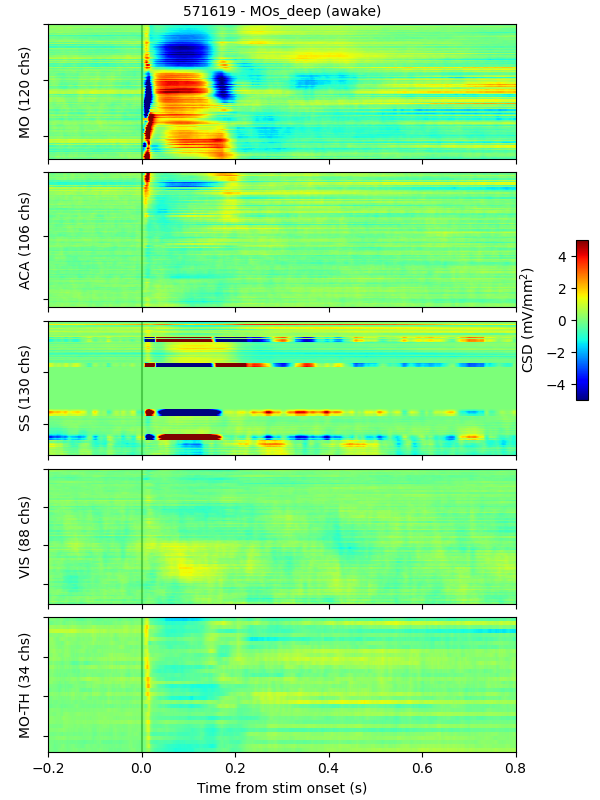

In [19]:
mm = '571619'
gg = 'MOs_deep'
plwin = [-0.2, 0.8]
vlevel = 5
plevel = 'medium'
statei = 'awake'

fig = plt.figure(figsize=(6, 8))
gs = fig.add_gridspec(
    ncols=2, nrows=1, width_ratios=[1, 0.05], left=0.08, right=0.98, top=0.97, bottom=0.06, wspace=0.2
)
CSDaxs = gs[0,0].subgridspec(ncols=1, nrows=len(areas_of_interest), hspace=0.1).subplots(sharex=True)

CSD_traces = ex_sub_dict[gg][mm]['data']['CSD'][plevel][statei]
LFP_traces = ex_sub_dict[gg][mm]['data']['LFP'][plevel][statei]

## Plot unit z-score activity ##
for kk, region in enumerate(areas_of_interest.keys()):
    ax = CSDaxs[kk]
    ax.set_yticklabels([])
    ax.axvline(0, color='g', alpha=0.4)
    if region not in CSD_traces.keys():
        continue

    ## LFP ##
    travg_LFP = np.mean(LFP_traces[region][1], axis=2) * 5E-2 # *1E-3 makes it mV

    ## CSD ##
    imcsd = ax.imshow(
        np.mean(- CSD_traces[region][1] * 10, axis=2).T, cmap='jet', #'bwr' ## - CSD * 10 um > mV/mm^2 ##
        aspect='auto', origin='upper', vmin=-vlevel, vmax=vlevel, interpolation='none',
        extent=[CSD_traces[region][0][0], CSD_traces[region][0][-1], CSD_traces[region][1].shape[1], 0]
    )

    ## Overlay LFP traces ##
#     for chi in range(0, travg_LFP.shape[1], 10):
#         ax.plot(LFP_traces[region][0], travg_LFP[:, chi] + chi, color='k', linewidth=1, alpha=0.2)
    ax.set_ylabel('{} ({:d} chs)'.format(region, CSD_traces[region][1].shape[1]))
    ax.set_xlim(plwin)
    ax.set_ylim(CSD_traces[region][1].shape[1], 0)

CSDaxs[-1].set_xlabel('Time from stim onset (s)')
CSDaxs[0].set_title('{} - {} ({})'.format(mm, gg, statei))

## Add the colorbar ##
lcbax = fig.add_axes([0.96, 0.5, 0.02, 0.2])
lcb = Colorbar(ax=lcbax, mappable=imcsd, orientation='vertical', ticklocation='left')
# lcb.set_ticks([-1,0,1])
fig.text(0.88, 0.6, 'CSD ($\mathregular{mV/mm^2}$)', rotation='vertical', va='center', ha='center', fontsize=10)

## Save ##
figname = 'CSDwLFP_{}_{}.png'.format(mouse, statei)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

<IPython.core.display.Javascript object>


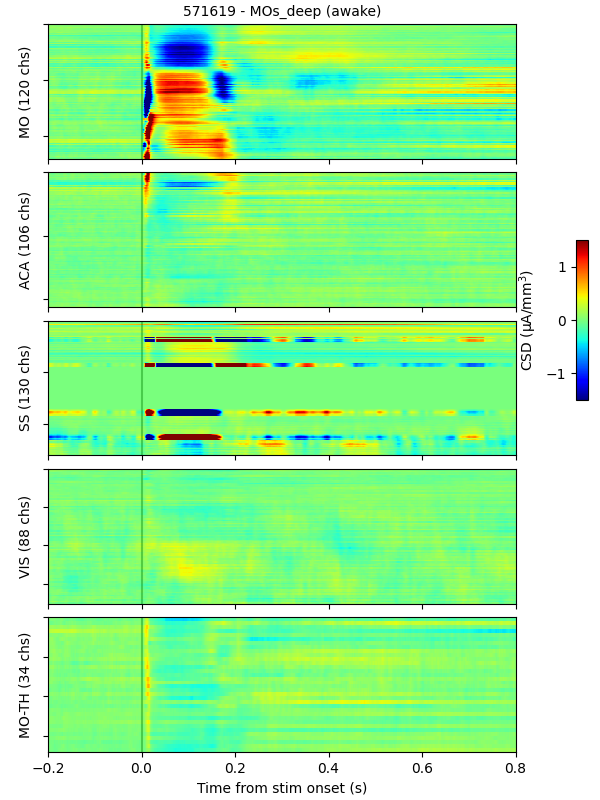

In [23]:
mm = '571619'
gg = 'MOs_deep'
plwin = [-0.2, 0.8]
vlevel = 1.5
plevel = 'medium'
statei = 'awake'

fig = plt.figure(figsize=(6, 8))
gs = fig.add_gridspec(
    ncols=2, nrows=1, width_ratios=[1, 0.05], left=0.08, right=0.98, top=0.97, bottom=0.06, wspace=0.2
)
CSDaxs = gs[0,0].subgridspec(ncols=1, nrows=len(areas_of_interest), hspace=0.1).subplots(sharex=True)

CSD_traces = ex_sub_dict[gg][mm]['data']['CSD'][plevel][statei]
LFP_traces = ex_sub_dict[gg][mm]['data']['LFP'][plevel][statei]

## Plot unit z-score activity ##
for kk, region in enumerate(areas_of_interest.keys()):
    ax = CSDaxs[kk]
    ax.set_yticklabels([])
    ax.axvline(0, color='g', alpha=0.4)
    if region not in CSD_traces.keys():
        continue

    ## LFP ##
    travg_LFP = np.mean(LFP_traces[region][1], axis=2) * 5E-2 # *1E-3 makes it mV

    ## CSD ##
    imcsd = ax.imshow(
        np.mean(-0.3 * CSD_traces[region][1] * 10, axis=2).T, cmap='jet', #'bwr' # - 0.3 * CSD * 10 > uA/mm^3 #
        aspect='auto', origin='upper', vmin=-vlevel, vmax=vlevel, interpolation='none',
        extent=[CSD_traces[region][0][0], CSD_traces[region][0][-1], CSD_traces[region][1].shape[1], 0]
    )

    ## Overlay LFP traces ##
#     for chi in range(0, travg_LFP.shape[1], 10):
#         ax.plot(LFP_traces[region][0], travg_LFP[:, chi] + chi, color='k', linewidth=1, alpha=0.2)
    ax.set_ylabel('{} ({:d} chs)'.format(region, CSD_traces[region][1].shape[1]))
    ax.set_xlim(plwin)
    ax.set_ylim(CSD_traces[region][1].shape[1], 0)

CSDaxs[-1].set_xlabel('Time from stim onset (s)')
CSDaxs[0].set_title('{} - {} ({})'.format(mm, gg, statei))

## Add the colorbar ##
lcbax = fig.add_axes([0.96, 0.5, 0.02, 0.2])
lcb = Colorbar(ax=lcbax, mappable=imcsd, orientation='vertical', ticklocation='left')
# lcb.set_ticks([-1,0,1])
fig.text(0.88, 0.6, 'CSD ($\mathregular{\u03bcA/mm^3}$)', rotation='vertical', va='center', ha='center', fontsize=10)

## Save ##
figname = 'CSDwLFP_{}_{}.png'.format(mouse, statei)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### Plot LFP and CSD for superficial and deep (one state) - comparing superficial and deep stim (like Figure 2)

<IPython.core.display.Javascript object>


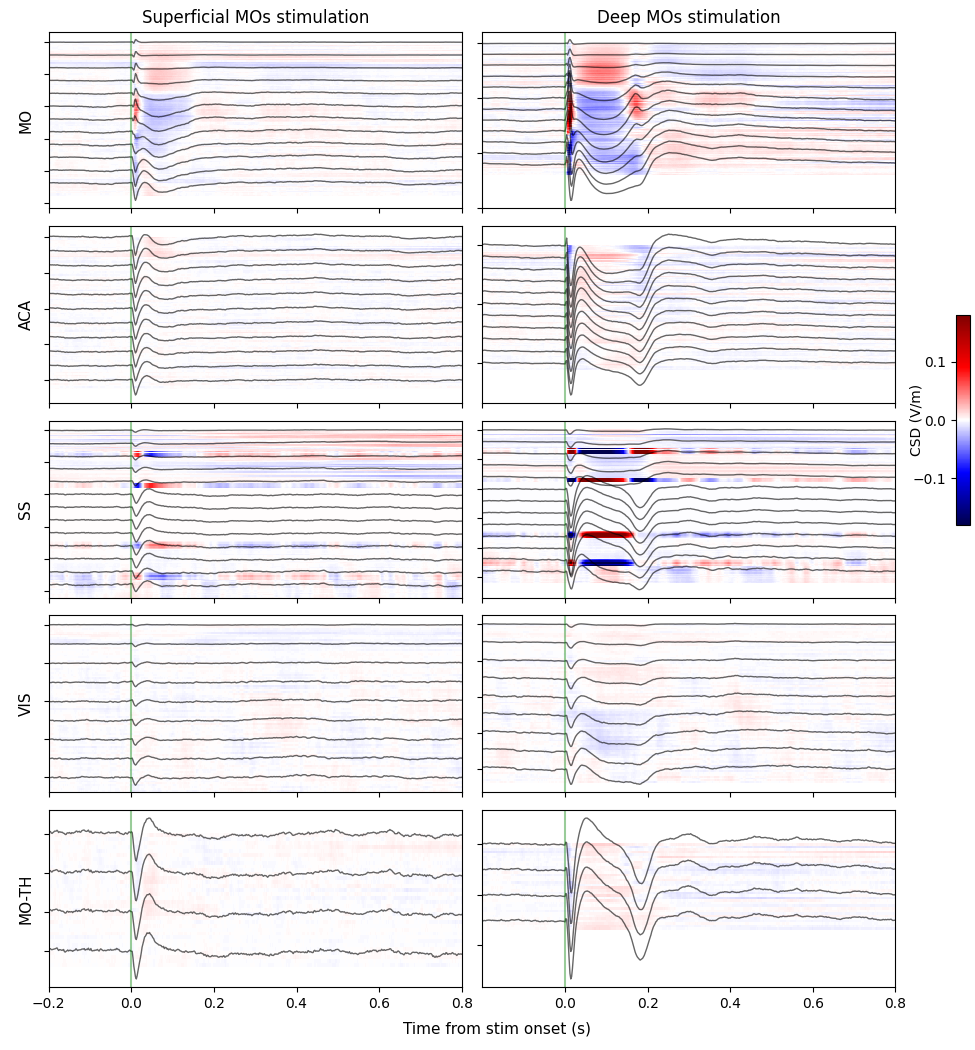

In [38]:
## move color bars to right ##
plwin = [-0.2, 0.8]
vlevel = 0.18
plevel = 'medium'
statei = 'awake'

fig = plt.figure(figsize=(9.75, 10.5))
gs = fig.add_gridspec(
    ncols=2, nrows=1, width_ratios=[1, 0.02], left=0.05, right=0.98, top=0.97, bottom=0.06, wspace=0.1, hspace=0.04
)
CSDaxs = gs[0,0].subgridspec(ncols=len(example_mice), nrows=len(areas_of_interest), hspace=0.1, wspace=0.05).subplots()

for ii, (group, mouse) in enumerate(example_mice.items()):
    CSD_traces = ex_sub_dict[group][mouse]['data']['CSD'][plevel]
    LFP_traces = ex_sub_dict[group][mouse]['data']['LFP'][plevel]

    ## Plot unit z-score activity ##
    for kk, region in enumerate(areas_of_interest.keys()):
        if region not in CSD_traces[statei].keys():
            continue
            
        ## LFP ##
        travg_LFP = np.mean(LFP_traces[statei][region][1], axis=2) * 5E-2 # *1E-3 makes it mV
        
        ## CSD ##
        ax = CSDaxs[kk, ii]
        imcsd = ax.imshow(
            np.mean(CSD_traces[statei][region][1], axis=2).T / 10, cmap='seismic', #'bwr' # CSD / 10 um > V/m #
            aspect='auto', origin='upper', vmin=-vlevel, vmax=vlevel,# interpolation='none',
            extent=[CSD_traces[statei][region][0][0], CSD_traces[statei][region][0][-1],
                    CSD_traces[statei][region][1].shape[1], 0]
        )
        
        ## Overlay LFP traces ##
        for chi in range(0, travg_LFP.shape[1], 10):
            ax.plot(LFP_traces[statei][region][0], travg_LFP[:, chi] + chi, color='k', linewidth=1, alpha=0.6)
        
        ax.set_xlim(plwin)
        ax.axvline(0, color='g', alpha=0.4)
        ax.set_yticklabels([])
        if kk < len(areas_of_interest)-1:
            ax.set_xticklabels([])
        if ii == 0:
            ax.set_ylabel(region, fontsize=11)
#             ax.set_ylabel('LFP\n({:d} chs)'.format(LFP_traces[statei][region][1].shape[1]), fontsize=10)
ax.set_xticks(ax.get_xticks()[1:])
                
fig.text(0.51, 0.02, 'Time from stim onset (s)', va='center', ha='center', fontsize=11)

CSDaxs[0,0].set_title('Superficial MOs stimulation', fontsize=12)
CSDaxs[0,1].set_title('Deep MOs stimulation', fontsize=12)

## Add the colorbar ##
lcbax = fig.add_axes([0.98, 0.5, 0.015, 0.2])
lcb = Colorbar(ax=lcbax, mappable=imcsd, orientation='vertical', ticklocation='left')
# lcb.set_ticks([-1,0,1])
fig.text(0.94, 0.6, 'CSD (V/m)', rotation='vertical', va='center', ha='center', fontsize=10)

## Save ##
figname = 'CSDwLFP_{}_{}.png'.format(mouse, statei)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### Plot CSD for superficial and deep (one state)

<IPython.core.display.Javascript object>


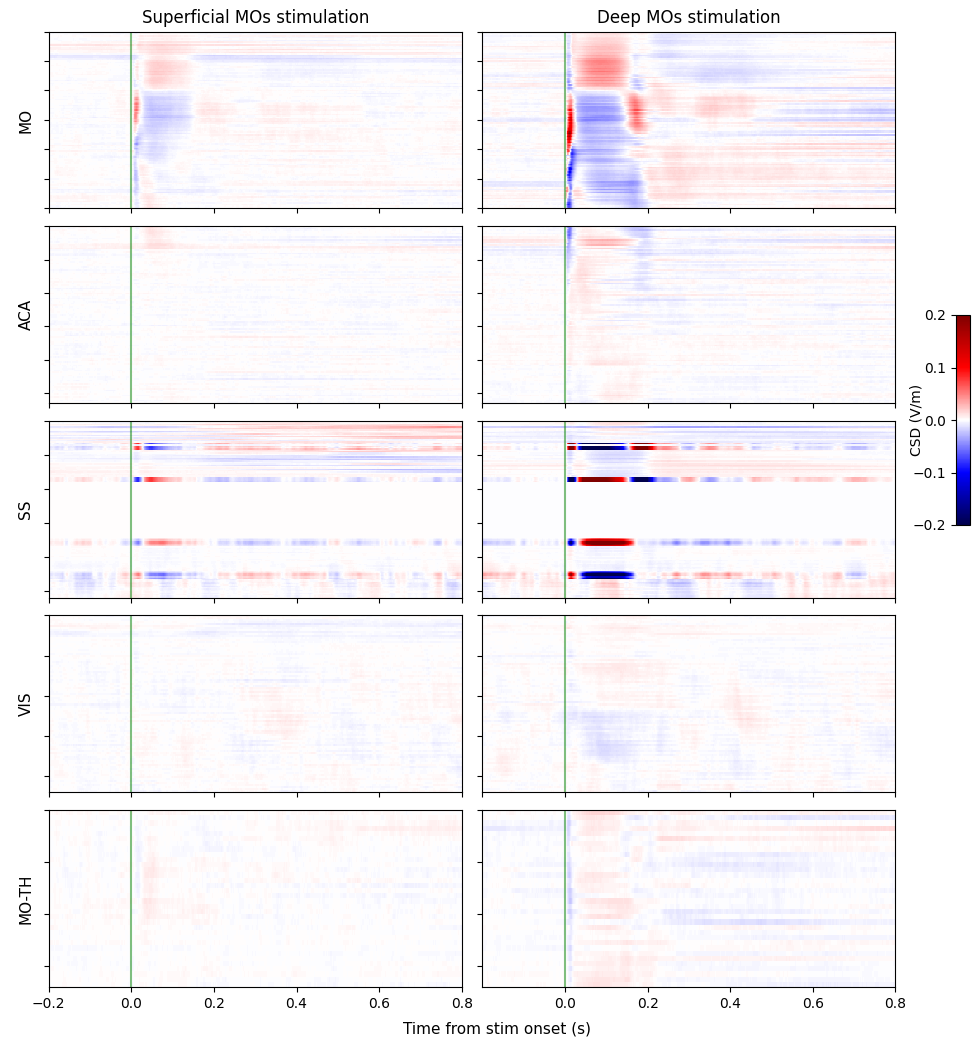

In [18]:
## move color bars to right ##
plwin = [-0.2, 0.8]
vlevel = 0.2
plevel = 'medium'
statei = 'awake'

fig = plt.figure(figsize=(9.75, 10.5))
gs = fig.add_gridspec(
    ncols=2, nrows=1, width_ratios=[1, 0.02], left=0.05, right=0.98, top=0.97, bottom=0.06, wspace=0.1, hspace=0.04
)
CSDaxs = gs[0,0].subgridspec(ncols=len(example_mice), nrows=len(areas_of_interest), hspace=0.1, wspace=0.05).subplots()

for ii, (group, mouse) in enumerate(example_mice.items()):
    CSD_traces = ex_sub_dict[group][mouse]['data']['CSD'][plevel]
#     LFP_traces = ex_sub_dict[group][mouse]['data']['LFP'][plevel]

    ## Plot unit z-score activity ##
    for kk, region in enumerate(areas_of_interest.keys()):
        if region not in CSD_traces[statei].keys():
            continue
        ## CSD ##
        ax = CSDaxs[kk, ii]
        imcsd = ax.imshow(
            np.mean(CSD_traces[statei][region][1], axis=2).T / 10, cmap='seismic', #'bwr' ## UNITS ##
            interpolation='none', aspect='auto', origin='upper', vmin=-vlevel, vmax=vlevel,
            extent=[CSD_traces[statei][region][0][0], CSD_traces[statei][region][0][-1],
                    CSD_traces[statei][region][1].shape[1], 0]
        )
        ax.set_xlim(plwin)
        ax.axvline(0, color='g', alpha=0.5)
        ax.set_yticklabels([])
        if kk < len(areas_of_interest)-1:
            ax.set_xticklabels([])
        if ii == 0:
            ax.set_ylabel(region, fontsize=11)
#             ax.set_ylabel('LFP\n({:d} chs)'.format(LFP_traces[statei][region][1].shape[1]), fontsize=10)
ax.set_xticks(ax.get_xticks()[1:])
                
fig.text(0.51, 0.02, 'Time from stim onset (s)', va='center', ha='center', fontsize=11)

CSDaxs[0,0].set_title('Superficial MOs stimulation', fontsize=12)
CSDaxs[0,1].set_title('Deep MOs stimulation', fontsize=12)

## Add the colorbar ##
lcbax = fig.add_axes([0.98, 0.5, 0.015, 0.2])
lcb = Colorbar(ax=lcbax, mappable=imcsd, orientation='vertical', ticklocation='left')
# lcb.set_ticks([-1,0,1])
fig.text(0.94, 0.6, 'CSD (V/m)', rotation='vertical', va='center', ha='center', fontsize=10)

## Save ##
figname = 'CSD_{}_{}.png'.format(mouse, statei)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Gather EEG, LFP, and unit data for example subjects

In [15]:
apply_car = True

ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
time_bin = 0.0025 # size of time bins (s)
plot_cell_type = 'RS' # Can choose 'RS' or 'FS', only applies to the cortical regions, can't plot both together

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

In [16]:
for group, group_subs in ex_sub_dict.items():
    print(group)
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        mdata['data'] = {}
        
        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue
        
        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        if len(currents_list) > 1:
            PCI_stim_amp = currents_list[1]
        elif len(currents_list) == 1:
            PCI_stim_amp = currents_list[0]
        else:
            print('No stim current listed in Zap_Zip-log_exp')

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        timex = bins[:-1] + time_bin/2
        
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        mdata['good_chs'] = GOOD_CHS
        
        ## Load LFP info and traces ##
        with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
            LFPinfo = json.load(info_file)
        LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
            
        ## Load regional stuff ##
        reg_allLFPtraces = {}
        reg_unit_info = {}
        for region in areas_of_interest.keys():
            if region in LFPinfo.keys():
                reg_allLFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
            if region in ctx_regions:
                regdf = unit_info[(unit_info['cell_type'] == plot_cell_type) & (unit_info['parent'] == region)]
            else:
                regdf = unit_info[unit_info['parent'] == region]
            if len(regdf) > 0:
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
        
        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in ['awake', 'anesthetized']:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][statei] = np.concatenate(state_events)
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)
        
        EEG_traces = {}
        LFP_traces = {}
        unit_traces = {}
        for leveli, states_event_times in all_event_inds.items():
            EEG_traces[leveli] = {}
            LFP_traces[leveli] = {}
            unit_traces[leveli] = {}
            for statei in test_states:
                event_inds = states_event_times[statei]
                LFP_traces[leveli][statei] = {}
                unit_traces[leveli][statei] = {}
                ## Get evoked EEG traces ##
                event_traces = all_EEG_traces[:, :, event_inds]
                if apply_car:
                    event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                EEG_traces[leveli][statei] = [EEG_event_timestamps, event_traces]

                for region in areas_of_interest.keys():
                    ## Get evoked LFP traces ##
                    if region in reg_allLFPtraces.keys():
                        LFP_traces[leveli][statei][region] = [LFP_event_ts, reg_allLFPtraces[region][:, :, event_inds]]

                    ## Get unit z-score ##
                    if region in reg_unit_info.keys():
                        unit_firing_rates = np.zeros((len(timex), len(reg_unit_info[region])), dtype=float) * np.nan
                        for ii, unitrow in reg_unit_info[region].iterrows():
                            unit_event_spikes = [
                                all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
                            unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
                            unit_firing_rates[:, ii] = unit_event_counts / (time_bin * len(event_inds))
                        unit_traces[leveli][statei][region] = [timex, get_zFR(unit_firing_rates, timex)]
        
        mdata['data']['EEG'] = EEG_traces
        mdata['data']['LFP'] = LFP_traces
        mdata['data']['unit_zscores'] = unit_traces
        
        ### After each subject, delete common variables ###
        del stim_log
        del all_EEG_traces, EEG_event_timestamps
        del reg_allLFPtraces, LFP_event_ts, LFPinfo
        del unit_info, all_unit_event_spikes, reg_unit_info
        del EEG_traces, LFP_traces, unit_traces
    print('')

MOs_superficial
 571619

MOs_deep
 571619



### Plot figure 2: superficial and deep examples with EEG and unit zscores for AWAKE only

<IPython.core.display.Javascript object>


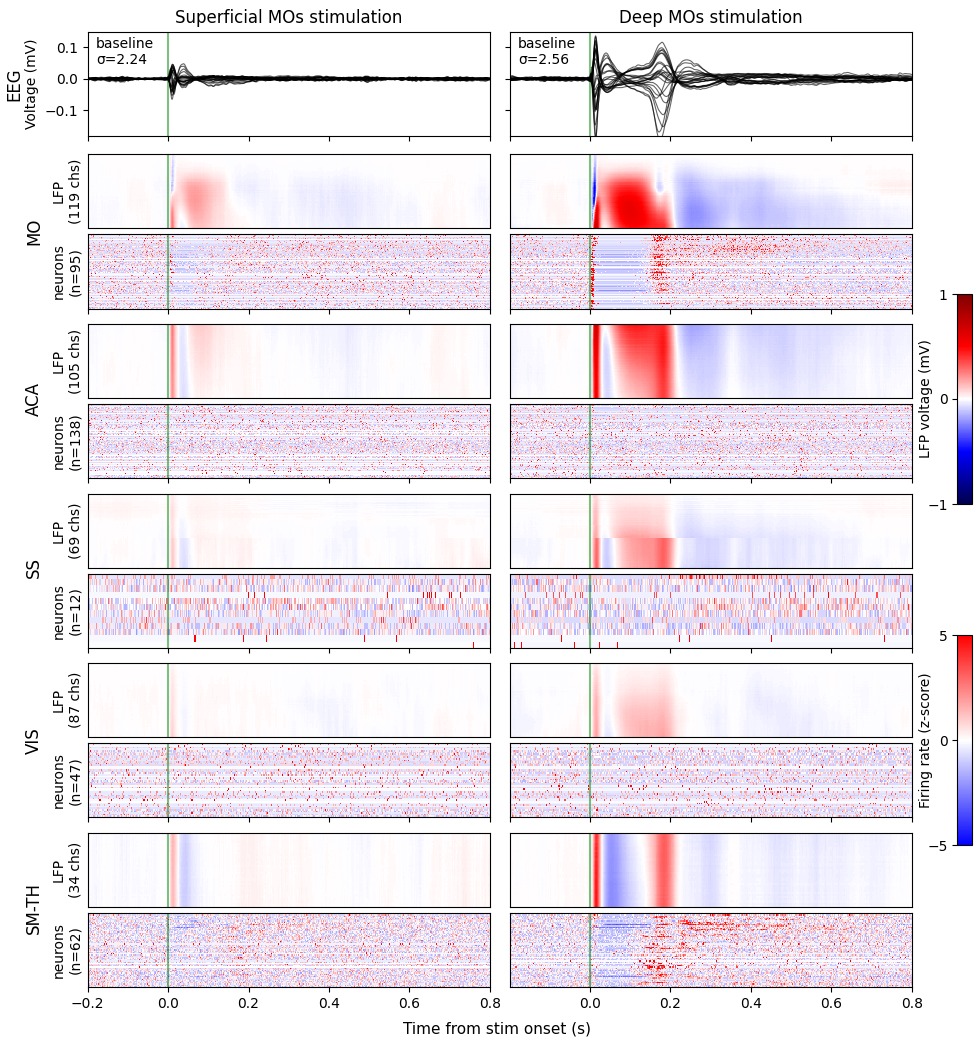

In [21]:
## move color bars to right ##
plwin = [-0.2, 0.8]
eeg_ylim = [-0.18, 0.15]
vlevel = 1.0
Zlim = 5
plevel = 'medium'
statei = 'awake'

fig = plt.figure(figsize=(9.75, 10.5))
gs = fig.add_gridspec(
    ncols=2, nrows=2, height_ratios=[1, 8], width_ratios=[1, 0.02], left=0.09, right=0.995, top=0.97, bottom=0.06,
    wspace=0.1, hspace=0.04)
EEGaxs = gs[0,0].subgridspec(ncols=len(example_mice), nrows=1, wspace=0.05).subplots(sharex=True, sharey=True)
NPXgs = gs[1,0].subgridspec(ncols=len(example_mice), nrows=len(areas_of_interest), hspace=0.1, wspace=0.05)

for ii, (group, mouse) in enumerate(example_mice.items()):
    EEG_traces = ex_sub_dict[group][mouse]['data']['EEG'][plevel]
    LFP_traces = ex_sub_dict[group][mouse]['data']['LFP'][plevel]
    unitZ = ex_sub_dict[group][mouse]['data']['unit_zscores'][plevel]
    GOOD_CHS = ex_sub_dict[group][mouse]['good_chs']
    
    coli = ii
    ## Plot EEG traces ##
    EEGaxs[coli].axvline(0, color='g', alpha=0.5)
    EEGaxs[coli].plot(
        EEG_traces[statei][0], np.mean(EEG_traces[statei][1][:, GOOD_CHS, :], axis=2) / 1E3, 'k', linewidth=0.8, alpha=0.6)
    EEGaxs[coli].set_xlim(plwin)
    EEGaxs[coli].set_xticklabels([])
    EEGaxs[coli].set_ylim(eeg_ylim)
    if coli == 0:
        EEGaxs[coli].set_ylabel('Voltage (mV)', fontsize=10)
    BLstd = np.std(np.mean(EEG_traces[statei][1][:, GOOD_CHS, :], axis=2)[EEG_traces[statei][0] < 0, :])
    EEGaxs[coli].annotate(
        'baseline\n\u03c3={:.2f}'.format(BLstd), xy=(0.02, 0.95), xycoords='axes fraction', fontsize=10, ha='left', va='top'
    )

    ## Plot unit z-score activity ##
    for kk, region in enumerate(areas_of_interest.keys()):
        if region not in unitZ[statei].keys():
            continue
        NPXaxs = NPXgs[kk,coli].subgridspec(nrows=2, ncols=1, hspace=0.08).subplots()
        ## LFP ##
        imlfp = NPXaxs[0].imshow(
            np.mean(LFP_traces[statei][region][1], axis=2).T / 1E3, cmap='seismic', #'bwr'
            interpolation='none', aspect='auto', origin='upper', vmin=-vlevel, vmax=vlevel,
            extent=[LFP_traces[statei][region][0][0], LFP_traces[statei][region][0][-1],
                    LFP_traces[statei][region][1].shape[1], 0]
        )
        NPXaxs[0].set_xlim(plwin)
        NPXaxs[0].axvline(0, color='g', alpha=0.5)
        NPXaxs[0].set_xticks([])
        NPXaxs[0].set_xticklabels([])
        NPXaxs[0].set_yticks([])
        ## Z-scores ##
        imunit = NPXaxs[1].imshow(
            unitZ[statei][region][1].T, cmap='bwr',
            interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
            extent=[unitZ[statei][region][0][0], unitZ[statei][region][0][-1], 0, unitZ[statei][region][1].shape[0]],
        )
        NPXaxs[1].set_xlim(plwin)
        NPXaxs[1].axvline(0, color='g', alpha=0.5)
        if kk < len(areas_of_interest)-1:
            NPXaxs[1].set_xticklabels([])
        NPXaxs[1].set_yticks([])
        if coli == 0:
#             NPXaxs[0].set_ylabel('LFP', fontsize=11)
            NPXaxs[0].set_ylabel('LFP\n({:d} chs)'.format(LFP_traces[statei][region][1].shape[1]), fontsize=10)
            NPXaxs[1].set_ylabel('neurons\n(n={:d})'.format(unitZ[statei][region][1].shape[1]), fontsize=10)
NPXaxs[1].set_xticks(NPXaxs[1].get_xticks()[1:])

fig.text(0.015, 0.92, 'EEG', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.035, 0.78, 'MO', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.035, 0.62, 'ACA', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.035, 0.46, 'SS', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.035, 0.295, 'VIS', rotation='vertical', va='center', ha='center', fontsize=12)
fig.text(0.035, 0.135, 'SM-TH', rotation='vertical', va='center', ha='center', fontsize=12)
                
fig.text(0.51, 0.02, 'Time from stim onset (s)', va='center', ha='center', fontsize=11)

EEGaxs[0].set_title('Superficial MOs stimulation', fontsize=12)
EEGaxs[1].set_title('Deep MOs stimulation', fontsize=12)

## Add the colorbar ##
lcbax = fig.add_axes([0.982, 0.52, 0.015, 0.2])
lcb = Colorbar(ax=lcbax, mappable=imlfp, orientation='vertical', ticklocation='left')
lcb.set_ticks([-1,0,1])
fig.text(0.95, 0.62, 'LFP voltage (mV)', rotation='vertical', va='center', ha='center', fontsize=10)

ucbax = fig.add_axes([0.982, 0.195, 0.015, 0.2])
ucb = Colorbar(ax=ucbax, mappable=imunit, orientation='vertical', ticklocation='left')
ucb.set_ticks([-5,0,5])
fig.text(0.95, 0.295, 'Firing rate (z-score)', rotation='vertical', va='center', ha='center', fontsize=10)

## Save ##
figname = 'Fig2_EEG_LFP_unitZ_{}only_{}_{}.png'.format(plot_cell_type, statei, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)